In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
data = pd.read_csv('data_cleaned.csv', low_memory=False)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data

,Date,Time,Inning,PitchNo,PAofInning,PitchofPA,Batter,BatterTeam,Pitcher,PitcherTeam,...,Strikes,Runners,Count,PitchCall,PlayResult,TaggedPitchType,PlateLocHeight,PlateLocSide,ERV_delta,target
0,2024-02-16,10:09:21.840000,1,1,1,1,"Alvarez, Julian",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,0,0,5,InPlay,Out,Fastball,2.30371,-0.09952,-0.348639,0.020706
1,2024-02-16,10:09:53.220000,1,2,2,1,"Ostrander, Garrett",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,0,0,5,BallCalled,Undefined,Fastball,2.20297,1.03802,0.052979,0.079671
2,2024-02-16,10:10:08.560000,1,3,2,2,"Ostrander, Garrett",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,0,0,6,BallCalled,Undefined,Fastball,1.84496,-2.62468,0.102889,0.115824
3,2024-02-16,10:10:24.490000,1,4,2,3,"Ostrander, Garrett",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,0,0,9,StrikeCalled,Undefined,Fastball,2.69952,-0.96273,-0.092655,-0.110529
4,2024-02-16,10:10:40.040000,1,5,2,4,"Ostrander, Garrett",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,1,0,7,BallCalled,Undefined,Fastball,1.31319,0.73596,0.143543,0.168174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425868,2024-06-24,22:30:21.830000,9,299,4,3,"Schott, Hayden",TEX_AGG,"Combs, Aaron",TEN_VOL,...,2,1,0,StrikeSwinging,Undefined,Fastball,3.18957,0.77831,-0.236023,0.032461
1425869,2024-06-24,22:31:02.160000,9,300,5,1,"Burton, Ted",TEX_AGG,"Combs, Aaron",TEN_VOL,...,0,1,5,StrikeCalled,Undefined,Fastball,3.09837,-0.84427,-0.063703,-0.081384
1425870,2024-06-24,22:31:58.150000,9,301,5,2,"Burton, Ted",TEX_AGG,"Combs, Aaron",TEN_VOL,...,1,1,2,StrikeSwinging,Undefined,Fastball,3.60768,-0.76626,-0.064763,-0.105402
1425871,2024-06-24,22:32:21.840000,9,302,5,3,"Burton, Ted",TEX_AGG,"Combs, Aaron",TEN_VOL,...,2,1,0,BallCalled,Undefined,Fastball,4.86704,-1.41462,1.029226,0.057252


In [4]:
# Separate swing from take data 
swing_data = data[data['Swing/Take'] == 'Swing'].copy()
take_data = data[data['Swing/Take'] == 'Take'].copy()

In [5]:
from matplotlib.colors import Normalize

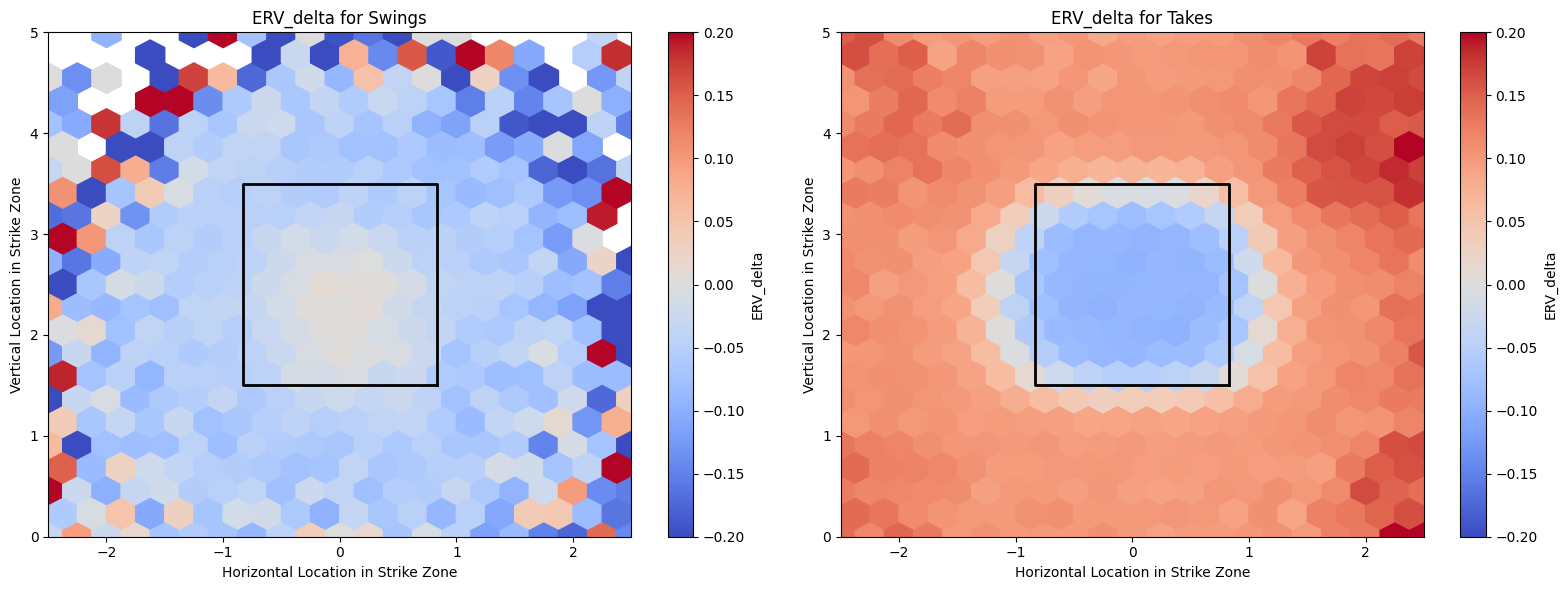

In [6]:
x_swings = swing_data['PlateLocSide']
y_swings = swing_data['PlateLocHeight']
erv_delta_swings = swing_data['ERV_delta']

x_takes = take_data['PlateLocSide']
y_takes = take_data['PlateLocHeight']
erv_delta_takes = take_data['ERV_delta']

strike_zone_x = [0.833, 0.833, -0.833, -0.833, 0.833]
strike_zone_y = [1.5, 3.5, 3.5, 1.5, 1.5]
x_range = (-2.5, 2.5)
y_range = (0, 5)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Hexbin plot for swings
hb_swings = axes[0].hexbin(
    x_swings, y_swings, C=erv_delta_swings, 
    gridsize=20, extent=(x_range[0], x_range[1], y_range[0], y_range[1]), 
    cmap='coolwarm', reduce_C_function=np.mean, 
    norm=Normalize(vmin=-0.2, vmax=0.2)
)
axes[0].plot(strike_zone_x, strike_zone_y, color='black', lw=2)
axes[0].set_xlim(x_range)
axes[0].set_ylim(y_range)
axes[0].set_title('ERV_delta for Swings')
axes[0].set_xlabel('Horizontal Location in Strike Zone')
axes[0].set_ylabel('Vertical Location in Strike Zone')
fig.colorbar(hb_swings, ax=axes[0], label='ERV_delta')

# Hexbin plot for takes
hb_takes = axes[1].hexbin(
    x_takes, y_takes, C=erv_delta_takes, 
    gridsize=20, extent=(x_range[0], x_range[1], y_range[0], y_range[1]), 
    cmap='coolwarm', reduce_C_function=np.mean, 
    norm=Normalize(vmin=-0.2, vmax=0.2)
)
axes[1].plot(strike_zone_x, strike_zone_y, color='black', lw=2)
axes[1].set_xlim(x_range)
axes[1].set_ylim(y_range)
axes[1].set_title('ERV_delta for Takes')
axes[1].set_xlabel('Horizontal Location in Strike Zone')
axes[1].set_ylabel('Vertical Location in Strike Zone')
fig.colorbar(hb_takes, ax=axes[1], label='ERV_delta')

plt.tight_layout()
plt.show()

In [7]:
# Splitting up the features from the target variable
X_swing = swing_data[['Outs', 'Balls', 'Strikes', 'PlateLocHeight', 'PlateLocSide']]
y_swing = swing_data['target']
X_take = take_data[['Outs', 'Balls', 'Strikes', 'PlateLocHeight', 'PlateLocSide']]
y_take = take_data['target']

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.ensemble import HistGradientBoostingRegressor

In [9]:
# # Hyper parameter tuning
# # Define the parameter grid for tuning
# param_grid = {
#     "learning_rate": [0.1],  # Test multiple learning rates
#     "max_iter": [100],  # Different numbers of boosting iterations
#     "max_depth": [3, 5, 7, 10, 12],  # Depth of trees
#     "max_leaf_nodes": [20, 50, 80, 100],  # Number of maximum leaf nodes
#     "min_samples_leaf": [5, 10, 20, 30],  # Minimum samples per leaf
#     "l2_regularization": [0.0, 0.1, 0.5, 1.0],  # Regularization strength
# }

# # Initialize the base model
# gbr_model = HistGradientBoostingRegressor(
#     early_stopping=True,  # Enable early stopping
#     random_state=42,  # Ensure reproducibility
# )

# # Perform Randomized Search with Cross-Validation
# grid_search = GridSearchCV(
#     gbr_model,
#     param_grid=param_grid,
#     scoring="neg_mean_squared_error",  # Minimize MSE
#     cv=5,  # 5-Fold Cross-Validation
#     n_jobs=-1,  # Use all CPU cores
# )

# grid_search.fit(X_swing, y_swing)

# # Get the best parameters
# print("Best Parameters:", grid_search.best_params_)

# # Get the best cross-validation MSE 
# best_cv_mse = -grid_search.best_score_  # Convert negative MSE to positive

# print(f"Best Cross-Validation MSE: {best_cv_mse:.6f}")

In [10]:
# Define features
columns_to_scale = ['PlateLocHeight', 'PlateLocSide']
columns_to_leave = ['Outs', 'Balls', 'Strikes']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale),
        ('passthrough', 'passthrough', columns_to_leave)
    ]
)

# HistGradientBoostingRegressor model (HistGradientBoost supports missing values)
gbr_model = HistGradientBoostingRegressor(
    learning_rate=0.01,
    max_iter=1000,
    l2_regularization=0.1,
    max_depth=7,
    min_samples_leaf=10,
    max_leaf_nodes=50,
    random_state=42
)

# Pipeline
pipeline_swing = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step
    ('model', gbr_model)             # Gradient Boosting model
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_swing, y_swing, test_size=0.2, random_state=42)

# Train model
pipeline_swing.fit(X_train, y_train)

# Predictions
y_pred = pipeline_swing.predict(X_test)
y_pred_train = pipeline_swing.predict(X_train)

# Train metrics
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("\nTraining Data Metrics:")
print(f"Mean Squared Error (MSE): {mse_train:.6f}")
print(f"R-squared (R²): {r2_train:.4f}")

# Test metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test Data Metrics:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"R-squared (R²): {r2:.4f}")

# Fitting the model to all of the data
pipeline_swing.fit(X_swing, y_swing)


Training Data Metrics:
Mean Squared Error (MSE): 0.004219
R-squared (R²): 0.4355
Test Data Metrics:
Mean Squared Error (MSE): 0.004245
R-squared (R²): 0.4327


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...), ('passthrough', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [11]:
import joblib
from joblib import dump

In [12]:
# Edit these paths to wherever you want store the model objects
dump(pipeline_swing, '../UCSB-Baseball-Apps/ucsb-hitter-report/swing_model.joblib')
dump(pipeline_swing, '../UCSB-Baseball-Apps/ucsb-pitcher-report/swing_model.joblib')

['../UCSB-Baseball-Apps/ucsb-pitcher-report/swing_model.joblib']

In [13]:
# # Hyper parameter tuning
# # Define the parameter grid for tuning
# param_grid = {
#     "learning_rate": [0.1],  # Test multiple learning rates
#     "max_iter": [100],  # Different numbers of boosting iterations
#     "max_depth": [3, 5, 7, 10, 12],  # Depth of trees
#     "max_leaf_nodes": [20, 50, 80, 100],  # Number of maximum leaf nodes
#     "min_samples_leaf": [5, 10, 20, 30],  # Minimum samples per leaf
#     "l2_regularization": [0.0, 0.1, 0.5, 1.0],  # Regularization strength
# }

# # Initialize the base model
# gbr_model = HistGradientBoostingRegressor(
#     early_stopping=True,  # Enable early stopping
#     random_state=42,  # Ensure reproducibility
# )

# # Perform Randomized Search with Cross-Validation
# grid_search = GridSearchCV(
#     gbr_model,
#     param_grid=param_grid,
#     scoring="neg_mean_squared_error",  # Minimize MSE
#     cv=5,  # 5-Fold Cross-Validation
#     n_jobs=-1,  # Use all CPU cores
# )

# grid_search.fit(X_take, y_take)

# # Get the best parameters
# print("Best Parameters:", grid_search.best_params_)

# # Get the best cross-validation MSE 
# best_cv_mse = -grid_search.best_score_  # Convert negative MSE to positive

# print(f"Best Cross-Validation MSE: {best_cv_mse:.6f}")

In [14]:
# Define features
columns_to_scale = ['PlateLocHeight', 'PlateLocSide']
columns_to_leave = ['Outs', 'Balls', 'Strikes']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale),
        ('passthrough', 'passthrough', columns_to_leave)
    ]
)

# HistGradientBoostingRegressor model (HistGradientBoost supports missing values)
gbr_model = HistGradientBoostingRegressor(
    learning_rate=0.01,
    max_iter=1000,
    max_depth=10,
    max_leaf_nodes = 50,
    min_samples_leaf = 30,
    random_state=42
)

# Pipeline
pipeline_take = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step
    ('model', gbr_model)             # Gradient Boosting model
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_take, y_take, test_size=0.2, random_state=42)

# Train model
pipeline_take.fit(X_train, y_train)

# Predictions
y_pred = pipeline_take.predict(X_test)
y_pred_train = pipeline_take.predict(X_train)

# Train metrics
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("\nTraining Data Metrics:")
print(f"Mean Squared Error (MSE): {mse_train:.6f}")
print(f"R-squared (R²): {r2_train:.4f}")

# Test metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test Data Metrics:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"R-squared (R²): {r2:.4f}")

# Fitting the model to all of the data
pipeline_take.fit(X_take, y_take)


Training Data Metrics:
Mean Squared Error (MSE): 0.003105
R-squared (R²): 0.7167
Test Data Metrics:
Mean Squared Error (MSE): 0.003111
R-squared (R²): 0.7158


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...), ('passthrough', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [15]:
# Edit these paths to wherever you want store the model objects
dump(pipeline_take, '../UCSB-Baseball-Apps/ucsb-hitter-report/take_model.joblib')
dump(pipeline_take, '../UCSB-Baseball-Apps/ucsb-pitcher-report/take_model.joblib')

['../UCSB-Baseball-Apps/ucsb-pitcher-report/take_model.joblib']

In [16]:
# Using the models to calculate Decision Value for every pitch
swing_data.loc[:, 'Decision Value'] = pipeline_swing.predict(swing_data)
take_data.loc[:, 'Decision Value'] = pipeline_take.predict(take_data)
swing_data.reset_index(drop=True, inplace=True)
take_data.reset_index(drop=True, inplace=True)
data = pd.concat([swing_data, take_data]).reset_index(drop=True)
data

,Date,Time,Inning,PitchNo,PAofInning,PitchofPA,Batter,BatterTeam,Pitcher,PitcherTeam,...,Runners,Count,PitchCall,PlayResult,TaggedPitchType,PlateLocHeight,PlateLocSide,ERV_delta,target,Decision Value
0,2024-02-16,10:09:21.840000,1,1,1,1,"Alvarez, Julian",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,0,5,InPlay,Out,Fastball,2.30371,-0.09952,-0.348639,0.020706,-0.028612
1,2024-02-16,10:11:24.860000,1,7,3,1,"Carpentier Jr., Michael",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,1,5,InPlay,Out,ChangeUp,2.89980,0.58183,-0.448813,0.020706,-0.038395
2,2024-02-16,10:11:59.140000,1,8,4,1,"Simon, Mitch",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,1,5,FoulBall,Undefined,Curveball,2.49621,0.30301,-0.063703,-0.082319,-0.030175
3,2024-02-16,10:13:36.660000,1,13,4,6,"Simon, Mitch",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,1,8,StrikeSwinging,Undefined,Slider,1.14981,-0.71486,0.426934,-0.203712,-0.096611
4,2024-02-16,10:16:17.880000,1,16,1,3,"Upstill, Nick",PEP_WAV,"Pirko, Lukas",CAL_LAN,...,0,4,StrikeSwinging,Undefined,Fastball,2.22671,0.08457,-0.126783,-0.115177,-0.026931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425868,2024-06-24,22:27:35.160000,9,293,3,2,"Appel, Jackson",TEX_AGG,"Combs, Aaron",TEN_VOL,...,2,2,BallCalled,Undefined,Fastball,5.68769,1.08448,0.045824,0.066155,0.065688
1425869,2024-06-24,22:28:36.820000,9,295,3,4,"Appel, Jackson",TEX_AGG,"Combs, Aaron",TEN_VOL,...,2,1,BallCalled,Undefined,ChangeUp,2.72777,1.99526,0.065342,0.090642,0.094548
1425870,2024-06-24,22:29:59.430000,9,298,4,2,"Schott, Hayden",TEX_AGG,"Combs, Aaron",TEN_VOL,...,1,2,StrikeCalled,Undefined,Fastball,3.24728,-0.61861,-0.114242,-0.103630,-0.033696
1425871,2024-06-24,22:31:02.160000,9,300,5,1,"Burton, Ted",TEX_AGG,"Combs, Aaron",TEN_VOL,...,1,5,StrikeCalled,Undefined,Fastball,3.09837,-0.84427,-0.063703,-0.081384,-0.031783


In [17]:
# DV grouped by batter
DV_hitters = (
    data.groupby(['Batter', 'BatterTeam'])
        .filter(lambda x: len(x) >= 100)
        .groupby(['Batter', 'BatterTeam'])['Decision Value']
        .mean()
        .reset_index()
)

DV_hitters['Decision Value'] = DV_hitters['Decision Value']*100
DV_hitters.sort_values('Decision Value', ascending=False)

,Batter,BatterTeam,Decision Value
789,"Divittorio, Anthony",COP_STA,3.922354
3334,"Zyons, Zac",BRY_BUL,3.538379
1636,"Kraemer, Jackson",RIC_SPI,3.252745
2800,"Souffrain, Manny",BET_WIL,3.191040
1007,"Gaither, Damon",COP_STA,3.160252
...,...,...,...
1102,"Grace, Jack",CRE_BLU,-0.339516
2047,"Modgling, Cole",TEX_ISL,-0.364227
2522,"Rodriguez, Jonathan",LON_DIR,-0.473206
2036,"Mistone, Luke",CAL_FUL,-0.552799


In [18]:
# Average DV per batter across D1 baseball (goes in the app)
# DV is normalized per 100 pitches
DV_hitters_average = DV_hitters['Decision Value'].mean()
DV_hitters_average

np.float64(1.2504045112136255)

In [19]:
# Average DV per batter on balls in play separated by pitch type (goes in the app)
DV_battedballs = data[data['PitchCall'] == 'InPlay'].groupby(['Batter', 'BatterTeam', 'TaggedPitchType'])['Decision Value'].mean().reset_index()
DV_battedballs.groupby('TaggedPitchType')['Decision Value'].mean()*100

TaggedPitchType
ChangeUp           -1.328206
Curveball           0.132818
Cutter             -1.949423
Fastball           -3.653857
FourSeamFastBall   -3.570837
Knuckleball        -0.111145
OneSeamFastBall    -3.847032
Other              -1.102966
Sinker             -3.524931
Slider             -0.378286
Splitter           -0.419707
TwoSeamFastBall    -3.681242
Undefined          -2.298328
Name: Decision Value, dtype: float64

In [20]:
# Average DV per batter for balls in play (goes in the app)
DV_battedballs['Decision Value'].mean()*100

np.float64(-1.99128360337445)

In [21]:
# Average DV per batter on swings separated by pitch type (goes in the app)
DV_swings = data[data['PitchCall'].isin(['InPlay', 'StrikeSwinging', 'FoulBall'])].groupby(['Batter', 'BatterTeam', 'TaggedPitchType'])['Decision Value'].mean().reset_index()
DV_swings.groupby('TaggedPitchType')['Decision Value'].mean()*100

TaggedPitchType
ChangeUp           -2.057315
Curveball          -0.698091
Cutter             -2.562291
Fastball           -3.707412
FourSeamFastBall   -3.549553
Knuckleball        -0.600768
OneSeamFastBall    -4.197893
Other              -1.595384
Sinker             -3.820053
Slider             -1.330340
Splitter           -1.021004
TwoSeamFastBall    -3.903902
Undefined          -3.013648
Name: Decision Value, dtype: float64

In [22]:
# Average DV per batter for swings (goes in the app)
DV_swings['Decision Value'].mean()*100

np.float64(-2.453699245393896)

In [23]:
# Creating the different location zones
conditions = [
    (data['PlateLocSide'].between(-0.558, 0.558)) & (data['PlateLocHeight'].between(1.75, 3)),
    (data['PlateLocSide'].between(-1.1, 1.1)) & (data['PlateLocHeight'].between(3, 3.833, inclusive='right')),
    (data['PlateLocSide'].between(-1.1, 1.1)) & (data['PlateLocHeight'].between(1.16, 1.75, inclusive='neither')),
    (((data['PlateLocSide'] > -1.1) & (data['PlateLocSide'] < -0.558)) | 
     ((data['PlateLocSide'] > 0.558) & (data['PlateLocSide'] < 1.1))) & 
    (data['PlateLocHeight'].between(1.75, 3, inclusive='neither')),
    ((data['PlateLocSide'].between(-1.67, 1.67)) & (data['PlateLocHeight'].between(0.5, 4.5))) &
    ~((data['PlateLocSide'].between(-1.1, 1.1)) & (data['PlateLocHeight'].between(1.16, 3.833))),
]

choices = ["Heart", "Top Shadow", "Bottom Shadow", "Side Shadow", "Chase"]

data['Zone'] = np.select(conditions, choices, default="Waste")

In [24]:
# Average DV per batter seperated by zones (needed for the app)
DV_zone = data.groupby(['Batter', 'BatterTeam', 'Zone'])['Decision Value'].mean().reset_index()
DV_zone.groupby('Zone')['Decision Value'].mean()*100

Zone
Bottom Shadow   -0.144549
Chase            6.435056
Heart           -4.196988
Side Shadow     -3.955572
Top Shadow      -0.799403
Waste            9.265180
Name: Decision Value, dtype: float64

In [25]:
# Standardized stat for DV
DV_hitters['DV+'] = 100*((DV_hitters['Decision Value'] - DV_hitters_average) / DV_hitters_average)
DV_hitters.sort_values('DV+', ascending=False)

,Batter,BatterTeam,Decision Value,DV+
789,"Divittorio, Anthony",COP_STA,3.922354,213.686843
3334,"Zyons, Zac",BRY_BUL,3.538379,182.978764
1636,"Kraemer, Jackson",RIC_SPI,3.252745,160.135415
2800,"Souffrain, Manny",BET_WIL,3.191040,155.200642
1007,"Gaither, Damon",COP_STA,3.160252,152.738339
...,...,...,...,...
1102,"Grace, Jack",CRE_BLU,-0.339516,-127.152469
2047,"Modgling, Cole",TEX_ISL,-0.364227,-129.128766
2522,"Rodriguez, Jonathan",LON_DIR,-0.473206,-137.844224
2036,"Mistone, Luke",CAL_FUL,-0.552799,-144.209575


In [26]:
# Calculating deception runs (metric derived from DV for pitchers)
swing_data.loc[:, 'Swing DV'] = pipeline_swing.predict(swing_data)
swing_data.loc[:, 'Take DV'] = pipeline_take.predict(swing_data)
swing_data.loc[:, 'Deception Runs'] = swing_data['Take DV'] - swing_data['Swing DV']
take_data.loc[:, 'Swing DV'] = pipeline_swing.predict(take_data)
take_data.loc[:, 'Take DV'] = pipeline_take.predict(take_data)
take_data.loc[:, 'Deception Runs'] = take_data['Swing DV'] - take_data['Take DV']
swing_data.reset_index(drop=True, inplace=True)
take_data.reset_index(drop=True, inplace=True)
data2 = pd.concat([swing_data, take_data]).reset_index(drop=True)
data2

,Date,Time,Inning,PitchNo,PAofInning,PitchofPA,Batter,BatterTeam,Pitcher,PitcherTeam,...,PlayResult,TaggedPitchType,PlateLocHeight,PlateLocSide,ERV_delta,target,Decision Value,Swing DV,Take DV,Deception Runs
0,2024-02-16,10:09:21.840000,1,1,1,1,"Alvarez, Julian",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,Out,Fastball,2.30371,-0.09952,-0.348639,0.020706,-0.028612,-0.028612,-0.080184,-0.051572
1,2024-02-16,10:11:24.860000,1,7,3,1,"Carpentier Jr., Michael",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,Out,ChangeUp,2.89980,0.58183,-0.448813,0.020706,-0.038395,-0.038395,-0.076386,-0.037991
2,2024-02-16,10:11:59.140000,1,8,4,1,"Simon, Mitch",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,Undefined,Curveball,2.49621,0.30301,-0.063703,-0.082319,-0.030175,-0.030175,-0.079655,-0.049481
3,2024-02-16,10:13:36.660000,1,13,4,6,"Simon, Mitch",CAL_LAN,"Scavone, Tommy",PEP_WAV,...,Undefined,Slider,1.14981,-0.71486,0.426934,-0.203712,-0.096611,-0.096611,0.287698,0.384309
4,2024-02-16,10:16:17.880000,1,16,1,3,"Upstill, Nick",PEP_WAV,"Pirko, Lukas",CAL_LAN,...,Undefined,Fastball,2.22671,0.08457,-0.126783,-0.115177,-0.026931,-0.026931,-0.109744,-0.082813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425868,2024-06-24,22:27:35.160000,9,293,3,2,"Appel, Jackson",TEX_AGG,"Combs, Aaron",TEN_VOL,...,Undefined,Fastball,5.68769,1.08448,0.045824,0.066155,0.065688,-0.076508,0.065688,-0.142196
1425869,2024-06-24,22:28:36.820000,9,295,3,4,"Appel, Jackson",TEX_AGG,"Combs, Aaron",TEN_VOL,...,Undefined,ChangeUp,2.72777,1.99526,0.065342,0.090642,0.094548,0.030474,0.094548,-0.064075
1425870,2024-06-24,22:29:59.430000,9,298,4,2,"Schott, Hayden",TEX_AGG,"Combs, Aaron",TEN_VOL,...,Undefined,Fastball,3.24728,-0.61861,-0.114242,-0.103630,-0.033696,-0.040351,-0.033696,-0.006655
1425871,2024-06-24,22:31:02.160000,9,300,5,1,"Burton, Ted",TEX_AGG,"Combs, Aaron",TEN_VOL,...,Undefined,Fastball,3.09837,-0.84427,-0.063703,-0.081384,-0.031783,-0.049847,-0.031783,-0.018064


In [27]:
# DR grouped by pitcher
DR_pitchers = (
    data2.groupby(['Pitcher', 'PitcherTeam'])
        .filter(lambda x: len(x) >= 100)
        .groupby(['Pitcher', 'PitcherTeam'])['Deception Runs']
        .mean()
        .reset_index()
)
DR_pitchers['Deception Runs'] = DR_pitchers['Deception Runs']*100
DR_pitchers.sort_values('Deception Runs', ascending=False)

,Pitcher,PitcherTeam,Deception Runs
2496,"Polk, Lakin",SOU_LIO,-2.495984
1200,"Gunter, Rye",HBU_HUS,-2.592356
1013,"Franco, Xavier",CSD_TRI,-2.658748
2627,"Riojas, Ruger",UTS_ROA,-2.736472
1592,"Jones, Will",NOR_HUS,-2.804107
...,...,...,...
2545,"Putnam, Jake",BUT_BUL,-11.190682
3360,"Wheeler, Owen",MAI_BLA,-11.253960
1167,"Greenzang, Jared",RID_BRO,-11.298978
2979,"Spadaccini, Teo",YAL_BUL,-12.266335


In [28]:
# Average DR per pitcher across D1 baseball (goes in the app)
# DR is normalized per 100 pitches
DR_pitchers_average = DR_pitchers['Deception Runs'].mean()
DR_pitchers_average

np.float64(-6.032427816832668)

In [29]:
# Standardized stat for DR
DR_pitchers['DR+'] = 100*((2*DR_pitchers_average - DR_pitchers['Deception Runs']) / DR_pitchers_average)
DR_pitchers.sort_values('DR+', ascending=False)

,Pitcher,PitcherTeam,Deception Runs,DR+
2496,"Polk, Lakin",SOU_LIO,-2.495984,158.623882
1200,"Gunter, Rye",HBU_HUS,-2.592356,157.026316
1013,"Franco, Xavier",CSD_TRI,-2.658748,155.925739
2627,"Riojas, Ruger",UTS_ROA,-2.736472,154.637299
1592,"Jones, Will",NOR_HUS,-2.804107,153.516104
...,...,...,...,...
2545,"Putnam, Jake",BUT_BUL,-11.190682,14.491235
3360,"Wheeler, Owen",MAI_BLA,-11.253960,13.442271
1167,"Greenzang, Jared",RID_BRO,-11.298978,12.696018
2979,"Spadaccini, Teo",YAL_BUL,-12.266335,-3.339943
